#### Much of this code is adapted from Professor David Stewart's (University of Iowa Dept. of Mathematics) base code

In [1]:
using LinearAlgebra
using Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [60]:
function F(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    alpha = get(params, "alpha", 0.1)
    delta = get(params, "delta", 0.05)
    beta = get(params, "beta", 1.0)
    f_max = get(params, "f_max", 1.0)
    f, m = xv 
    dfdt = alpha * f * (f_max - f) - beta * f * u[1]
    dmdt = delta * m + beta * f * u[1]
    func = [dfdt, dmdt]
    return func
end

function g(xv,verbose=0)
    return xv[2]
end

function dg(xv::Vector{Float64}, verbose=0) 
    return [0.0, -1.0]
end

dg (generic function with 2 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -f \\ f \end{bmatrix}$

In [61]:
function dFdu(xvect::Vector{Float64},u::Vector{Float64},params::Dict{String,Real},verbose=0)
    f = xv[1]
    beta = get(params, "beta", 1.0)
    grad = [-beta * f, beta * f]
    return reshape(grad,2,1)
end

dFdu (generic function with 4 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [4]:
dFdx_sample(t,xv,u) = let x = xv[1], y = xv[2]; [0 0 ;2x 0] end

dFdx_sample (generic function with 1 method)

In [62]:
function dFdx(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    f = xv[1]
    alpha = get(params, "alpha", 1.0)
    beta = get(params, "beta", 1.0)
    delta = get(params, "delta", 1.0)
    jacobian = [    -alpha * (1 - 2*f) + beta * u[1]    beta * f     ;  
                              beta * u[1]                 delta      ]
    return jacobian
end

dFdx (generic function with 6 methods)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [6]:
function forwardstep_sample(x0,t0,F::Function,u,h)
    N = size(u,2) # number of cols of u
    n = length(x0)
    xs = zeros(eltype(x0),n,N+1)
    xs[:,1] = x0
    for i = 0:N-1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1])
    end
    xs
end

forwardstep_sample (generic function with 1 method)

In [40]:
function forwardstep(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,params::Dict{String,Real},verbose=0)
    N = size(u,2) # number of cols of u
    n = length(xv)
    xs = zeros(eltype(xv),n,N+1)
    xs[:,1] = xv
    h = get(params,"h",0.1)
    for i = 0:N-1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1],params)
    end
    xs
end

forwardstep (generic function with 2 methods)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [8]:
function adjointstep_sample(λend::Vector{Float64},t0::Float64,dFdx::Function,xs::Matrix{Float64},u::Matrix{Float64},h::Float64)
    N = size(u,2)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xs[:,i+1],u[:,i+1])'*λs[:,i+2]
    end
    λs
end

adjointstep_sample (generic function with 1 method)

In [48]:
# filling in the lagrange multipliers 
function adjointstep(λend::Vector{Float64},t0::Float64,xv::Matrix{Float64},u::Matrix{Float64},dFdx::Function,params::Dict{String,Real},verbose=0)
    N = size(u,2)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    count = 0
    h = get(params,"h",0.1)
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xv[:,i+1],u[:,i+1],params)'*λs[:,i+2]
    end
    λs
end

adjointstep (generic function with 2 methods)

#### Objective function
$\quad$ $g(\textbf{x}_N)=G(\textbf{u}_{0}, \textbf{u}_{1}, ... , \textbf{u}_{N-1})$

where $g(\textbf{x}_k)$ is the output at each step $k$

In [10]:
function G_sample(x0,t0,u,h,F::Function,g::Function)
    xs = forwardstep_sample(x0,t0,F,u,h)
    g(xs[:,end])
end

G_sample (generic function with 1 method)

In [11]:
function G(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,g::Function,params::Dict{String,Real},verbose=0)
    xs = forwardstep(t0,xv,u,F,params)
    return g(xs[:,end])
end

G (generic function with 2 methods)

#### Gradient of objective function with respect to $\textbf{u}$
$\quad$ $\nabla_{u_{k}} g(\textbf{x}_{N}) = h\nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [12]:
function dG_sample(x0,t0,u,h,F::Function,dFdx::Function,dFdu::Function,dg::Function)
    xs = forwardstep_sample(x0,t0,F,u,h)
    λend = dg(xs[:,end])
    λs = adjointstep_sample(λend,t0,dFdx,xs,u,h)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:,i+1] = h*dFdu(t0+i*h,xs[:,i+1],u[:,i+1])'*λs[:,i+1]
    end
    dGval
end

dG_sample (generic function with 1 method)

In [13]:
function dG(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,dg::Function,params,verbose=0)
    h = get(params, "h", 0.1)
    xs = forwardstep(t0,xv,u,F,params)
    λend = dg(xv[:,end])
    λs = adjointstep(λend,t0,xs,u,dFdx,params)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:, i+1] = h*dFdu(xs[:, i+1],u[i+1],params)'*λs[:, i+1]
    end
    dGval
end

dG (generic function with 2 methods)

#### Projection of controls onto $\space \mathcal{U}$
$\quad$ Search direction: $\textbf{d}=[(\textbf{d}_{0})^T, (\textbf{d}_{2})^T, ... , (\textbf{d}_{N-1})^T]^T$\
$\quad$ New control: $\textbf{u}^{+}(\alpha) = Proj_{\mathcal{U}}(\textbf{u}+\alpha \textbf{d})$, $\space$ $\mathcal{U}$ convex

This is to incorporate the constraints $\textbf{u}_{k} \in U \space \forall k$

In [14]:
function proj_u(u,a,b)
    clamp.(u, a, b)
end

proj_u (generic function with 1 method)

#### Optimal Control Algorithm
Performs gradient descent in conjunction with backtracking line search on the iterates of $\textbf{u}$

In [15]:
function optcontrol_sample(x0,t0,u,h,
        F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,proj::Function;
        eps=1e-2,s0=1.0,c1=0.05,maxiter::Int=10_000,ulist=nothing,trace=0)    
    Gval = G_sample(x0,t0,u,h,F,g)
    Gvalold = Gval

    dGval = dG_sample(x0,t0,u,h,F,dFdx,dFdu,dg)

    
    firsttime = true
    iter = 0
    if ulist != nothing
        push!(ulist,u)
    end

    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        Gvalold = Gval
        s = s0
        unew = proj(u-s*dGval) # projected gradient descent
        Gval = G_sample(x0,t0,unew,h,F,g)
        steps = 0
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
            s = s / 2
            unew = proj(u-s*dGval)
            Gval = G_sample(x0,t0,unew,h,F,g)
            steps += 1
        end
        u = unew
        firsttime = false
        dGval = dG_sample(x0,t0,u,h,F,dFdx,dFdu,dg)
 
        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
    end
    (u,iter)
end

optcontrol_sample (generic function with 1 method)

In [29]:
function optcontrol(t0::Float64,x0::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,proj::Function,params::Dict{String,Real},ulist=nothing,trace=0)
    Gval = G(t0,x0,u,F,g,params,1)
    Gvalold = Gval
    dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,1)
    firsttime = true
    iter = 0
    c1 = get(params, "c1", 0.01)
    s0 = get(params, "s0", 1.0)
    h = get(params, "h", 0.1)
    maxiter = get(params, "maxiter", 10000)
    eps = get(params, "eps", 0.4)
    if ulist != nothing
        push!(ulist,u)
    end
    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        Gvalold = Gval
        s = s0
        unew = proj(u-s*dGval) # projected gradient descent
        Gval = G(t0,x0,unew,F,g,params,1)        
        count_linesearch=0
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
            s = s / 2
            unew = proj(u-s*dGval)
            Gval = G(t0,x0,unew,F,g,params,1)
            count_linesearch += 1
            if count_linesearch == 1
                break
            end
        end
        u = unew
        firsttime = false
        dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,0)

        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
    end
    (u,iter)
end

optcontrol (generic function with 4 methods)

#### Trying on sample problem

In [17]:
F_sample(t,xv,u) = let x = xv[1], y = xv[2]; [u[1]; x^2] end
dFdx_sample(t,xv,u) = let x = xv[1], y = xv[2]; [0 0 ;2x 0] end
dFdu_sample(t,xv,u) = reshape([1.0; 0.0],2,1)
g_sample(xv) = xv[2]
dg_sample(xv) = [0.0; 1.0]

dg_sample (generic function with 1 method)

In [18]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0; u = [0.5]; du = 1e-3*[0.7]
dFdu_sample(t,xv,u)

2×1 Matrix{Float64}:
 1.0
 0.0

In [19]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0; u = [0.5]; du = 1e-3*[0.7]
@show (F_sample(t,xv+dxv,u)-F_sample(t,xv-dxv,u)-2dFdx_sample(t,xv,u)*dxv)/norm(dxv)
@show (F_sample(t,xv,u+du)-F_sample(t,xv,u-du)-2*dFdu_sample(t,xv,u)*du)/norm(du)
@show (g_sample(xv+dxv)-g_sample(xv-dxv)-2*dot(dg_sample(xv),dxv))/norm(dxv)

((F_sample(t, xv + dxv, u) - F_sample(t, xv - dxv, u)) - (2 * dFdx_sample(t, xv, u)) * dxv) / norm(dxv) = [0.0, -1.053887001334176e-12]
((F_sample(t, xv, u + du) - F_sample(t, xv, u - du)) - 2 * dFdu_sample(t, xv, u) * du) / norm(du) = [1.7657006809049645e-14, 0.0]
((g_sample(xv + dxv) - g_sample(xv - dxv)) - 2 * dot(dg_sample(xv), dxv)) / norm(dxv) = 1.1097654886679491e-13


1.1097654886679491e-13

In [41]:
N = 20
h = 0.1
u = -ones(1,N)
xv0 = [1.0; 0.0]

params_sample = Dict(
    "alpha"=>0.5,
    "delta"=>0.5,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>40
)
xs_test = forwardstep_sample(xv0,0.0,F_sample,u,h)
println("xs_test: ", xs_test)
xs = forwardstep(0.0,xv0,u,F_sample,params_sample)
println()
println("xs: ",xs)

xs_test: [1.0 0.9 0.8 0.7000000000000001 0.6000000000000001 0.5000000000000001 0.40000000000000013 0.30000000000000016 0.20000000000000015 0.10000000000000014 1.3877787807814457e-16 -0.09999999999999987 -0.19999999999999987 -0.2999999999999999 -0.3999999999999999 -0.4999999999999999 -0.5999999999999999 -0.6999999999999998 -0.7999999999999998 -0.8999999999999998 -0.9999999999999998; 0.0 0.1 0.18100000000000002 0.24500000000000005 0.29400000000000004 0.33000000000000007 0.3550000000000001 0.3710000000000001 0.3800000000000001 0.3840000000000001 0.3850000000000001 0.3850000000000001 0.3860000000000001 0.3900000000000001 0.39900000000000013 0.41500000000000015 0.4400000000000001 0.4760000000000001 0.525 0.589 0.6699999999999999]


LoadError: MethodError: no method matching F_sample(::Float64, ::Vector{Float64}, ::Vector{Float64}, ::Dict{String, Real})

[0mClosest candidates are:
[0m  F_sample(::Any, ::Any, ::Any)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[17]:1[24m[39m


In [21]:
λend = dg_sample(xs[:,end])

2-element Vector{Float64}:
 0.0
 1.0

In [22]:
λs_sample = adjointstep_sample(λend,0.0,dFdx_sample,xs,u,h)

2×20 Matrix{Float64}:
 0.38  0.18  5.55112e-16  -0.16  -0.3  …  -0.52  -0.42  -0.3  -0.16  0.0
 1.0   1.0   1.0           1.0    1.0      1.0    1.0    1.0   1.0   1.0

In [23]:
λs = adjointstep(λend,0.0,xs,u,dFdx_sample,params_sample)

2×20 Matrix{Float64}:
 0.38  0.18  5.55112e-16  -0.16  -0.3  …  -0.52  -0.42  -0.3  -0.16  0.0
 1.0   1.0   1.0           1.0    1.0      1.0    1.0    1.0   1.0   1.0

In [24]:
dFdx_sample(0,xs[:,end-1],u[:,end])'*λend

2-element Vector{Float64}:
 -1.7999999999999996
  0.0

In [25]:
dFdx(0.0,xs[:,end-1],u[:,end][1],params_sample)'*λend

2-element Vector{Float64}:
 -1.0
  0.5

In [26]:
g_val_sample =G_sample(xv0,0.0,u,h,F_sample,g_sample)
println("G sample: ", g_val_sample)
println()
g_val = G(0.0,xv0,u,F_sample,g_sample,params_sample,0)
println("G: ",g_val)

G sample: 0.6699999999999999

G: 0.6699999999999999


In [27]:
dg_sample_val = dG_sample(xv0,0.0,u,h,F_sample,dFdx_sample,dFdu_sample,dg_sample)
println("dG sample: ", dg_sample_val)
println()
dg_val = dG(0.0,xv0,u,F_sample,dFdx_sample,dFdu_sample,dg_sample,params_sample,0)
println("dG val: ", dg_val)

dG sample: [0.03800000000000006 0.018000000000000058 5.551115123125783e-17 -0.01599999999999995 -0.02999999999999995 -0.041999999999999954 -0.05199999999999996 -0.05999999999999997 -0.06599999999999998 -0.06999999999999998 -0.07199999999999998 -0.07199999999999998 -0.06999999999999998 -0.06599999999999999 -0.05999999999999999 -0.05199999999999999 -0.041999999999999996 -0.029999999999999995 -0.015999999999999997 0.0]

dG val: [0.03800000000000006 0.018000000000000058 5.551115123125783e-17 -0.01599999999999995 -0.02999999999999995 -0.041999999999999954 -0.05199999999999996 -0.05999999999999997 -0.06599999999999998 -0.06999999999999998 -0.07199999999999998 -0.07199999999999998 -0.06999999999999998 -0.06599999999999999 -0.05999999999999999 -0.05199999999999999 -0.041999999999999996 -0.029999999999999995 -0.015999999999999997 0.0]


In [31]:
ulist = []
u = zeros(1,20)
h = 0.1


uopt_sample,iters_sample = optcontrol_sample(xv0,0.0,u,h,F_sample,dFdx_sample,dFdu_sample,g_sample,dg_sample,u->proj_u(u,-1.0,1.0),eps=1e-4,maxiter=40,ulist=ulist,trace=0)
print("sample uopt, iters: ", (uopt_sample, iters_sample))
println()
println()
uopt,iters = optcontrol(0.0,xv0,u,F_sample,dFdx_sample,dFdu_sample,g_sample,dg_sample,u->proj_u(u,-1.0,1.0),params_sample,ulist,0)
println("uopt, iters: ", (uopt,iters))

sample uopt, iters: ([-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -0.763617762482379 -0.5539419998277445 -0.39285570751443244 -0.2709330105199739 -0.18035807266659903 -0.11466458860898471 -0.06851054958216427 -0.03748319155703648 -0.017929602807851396 -0.00680896047221426 -0.0015627896305092015 0.0], 38)

uopt, iters: ([-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -0.763617762482379 -0.5539419998277445 -0.39285570751443244 -0.2709330105199739 -0.18035807266659903 -0.11466458860898471 -0.06851054958216427 -0.03748319155703648 -0.017929602807851396 -0.00680896047221426 -0.0015627896305092015 0.0], 38)


In [32]:
uopt

1×20 Matrix{Float64}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.00680896  -0.00156279  0.0

In [34]:
xsopt = forwardstep(0.0,xv0,uopt,F_sample,params_sample)

2×21 Matrix{Float64}:
 1.0  0.9  0.8    0.7    0.6    0.5   …  -0.0407103  -0.0408666  -0.0408666
 0.0  0.1  0.181  0.245  0.294  0.33      0.386606    0.386772    0.386939

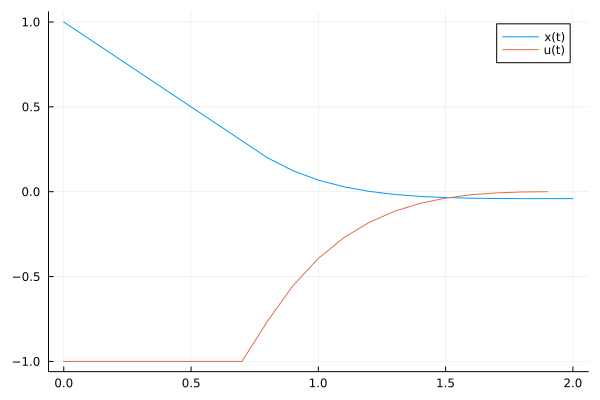

In [35]:
using Plots
plot(h*(0:20),xsopt[1,:],label="x(t)")
plot!(h*(0:19),uopt[1,:],label="u(t)")

#### Parameters

In [44]:
using LinearAlgebra
xv  = [2.1; 1.1]
t = 0.0; 
N = 200
u = -ones(1,N)
du = 1e-3*[0.7]
T = 20 

params = Dict(
    "alpha"=>0.5,
    "delta"=>0.5,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>10_000
)

Dict{String, Real} with 9 entries:
  "eps"     => 0.01
  "c1"      => 0.05
  "f_max"   => 1.0
  "maxiter" => 10000
  "alpha"   => 0.5
  "s0"      => 1.0
  "h"       => 0.1
  "delta"   => 0.5
  "beta"    => 1.0

In [45]:
xs = forwardstep(t,xv,u,F,params,0)

2×201 Matrix{Float64}:
 2.1  2.1945  2.28288  2.36474   2.43985   …       3.0       3.0       3.0
 1.1  0.945   0.7728   0.583152  0.375835     -68606.2  -72036.8  -75638.9

In [46]:
λend = dg(xs[:,end])

2-element Vector{Float64}:
  0.0
 -1.0

In [51]:
λs = adjointstep(λend,t,xs,u,dFdx,params)

2×200 Matrix{Float64}:
 -6.92087e8  -6.40928e8  -5.76723e8  …   0.36025   0.22     0.1    0.0
 -1.21194e6   1.27031e8   2.41517e8     -1.06013  -1.0725  -1.05  -1.0

In [53]:
ulist = []
u = fill(0.5, 1,N)
opt_u,iters = optcontrol(t,xv,u,F,dFdx,dFdu,g,dg,u->proj_u(u,0.0,0.5),params,ulist,0)

([0.5 0.5 … 0.5 0.5], 1)

In [54]:
opt_u

1×200 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [55]:
xsopt = forwardstep(t,xv,opt_u,F,params)

2×201 Matrix{Float64}:
 2.1  1.8795  1.70287  1.55788  1.43653  …      0.0944825      0.0940362
 1.1  1.26    1.41698  1.57297  1.72951     33616.8        35297.7

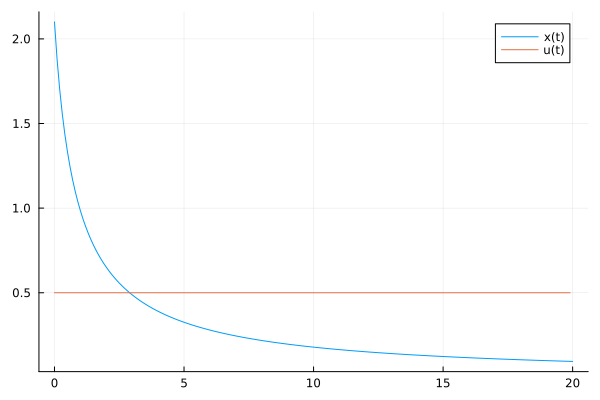

In [56]:
using Plots
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

#### Initial Parameters #1:
$\quad$ $T = 20\space years, \alpha = 0.1/year, \delta = 0.05/year, u_{max}=0.5, N=200, h=0.1$

## Optimal Fishing Effort - Addition of Predator

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u - \gamma f s\\ \gamma f s - \rho s \\ \delta m + \beta f u\end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1, \rho = 1, \alpha = 0.1, \gamma = 5$
#### So,
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(1-f)-f u \\ \delta m + f u \end{bmatrix}, x(0)=x_{0}, \textbf{u}(t)\in U  \space \forall t$

#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ -1 \end{bmatrix}$

In [231]:
function F_pred(t, x, u, alpha, delta, verbose=0)
    f, s, m = x
    dfdt = alpha * f * (1 - f) - f* u[1] - 5 * f * s
    dsdt = 5 * f * s - s
    dmdt = delta * m + u[1] * f

    if verbose == 1
        println("================================")
        println("[F] f: ", dfdt)
        println("[F] m: ", dfdt)
        println("[F] dfdf: ", dfdt)
        println("[F] dmdt: ", dfdt)
    end

    return [dfdt, dmdt]
end

function g(xv,verbose=0)
    if verbose == 1
        println("[g] g: ", -xv[2])
    end
    return -xv[2]
end

function dg(xv, verbose=0) 
    if verbose == 1
        println("[dg] dg: ", [0.0, 0.0, -1.0])
    end
    return [0.0, -1.0]
end

function dFdu_pred(t, xvect,u,alpha,delta,verbose=0)
    if verbose==1
        println("================================")
        println("[dFdu]: ",reshape([-xvect[1] ; xvect[1]],2,1))
    end
    return reshape([-xvect[1] ; xvect[1]],2,1)
end

function dFdx_pred(t, xv, u, alpha, delta,verbose=0)
    if verbose == 1
        println("================================")
        println("dFdx: ", [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta])
    end
    return [alpha - 2*alpha*xv[1] - u[1]  u[1];
                   0                    delta]
end

dFdx_pred (generic function with 2 methods)

In [232]:
using LinearAlgebra
xv  = [2.1; 1.1; 1.2]
dxv = 1e-3*[1.2; -0.7; 0.5]
t = 0; u = [0.5]; du = 1e-3*[0.7]
T = 20
alpha = 1
delta = 1
@show (F_pred(t,xv+dxv,u,alpha,delta)-F_pred(t,xv-dxv,u,alpha,delta)-2dFdx_pred(t,xv,u,alpha,delta)*dxv)/norm(dxv)
@show (F_pred(t,xv,u+du,alpha,delta,1)-F_pred(t,xv,u-du,alpha,delta,1)-2*dFdu_pred(t,xv,u,alpha,delta,1)*du)/norm(du)
@show (g_pred(xv+dxv,1)-g_pred|(xv-dxv,1)-2*dot(dg_pred(xv),dxv))/norm(dxv)

LoadError: cannot assign a value to imported variable Plots.alpha from module Main